<a href="https://colab.research.google.com/github/Namtk214/Vanishing-Gradient/blob/main/Solving_Gradient_Vanishing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import FashionMNIST

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

SEED = 42
set_seed(SEED)

In [3]:
train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 26.4M/26.4M [00:01<00:00, 20.9MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 334kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 6.17MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 6.79MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [4]:
train_ratio = 0.9
train_size = int(train_ratio * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Train subset size:", len(train_subset))
print("Validation subset size:", len(val_subset))
print("Test subset size:", len(test_dataset))

Train subset size: 54000
Validation subset size: 6000
Test subset size: 10000


In [8]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        x = self.layer3(x)
        x = nn.Sigmoid()(x)
        x = self.layer4(x)
        x = nn.Sigmoid()(x)
        x = self.layer5(x)
        x = nn.Sigmoid()(x)
        x = self.layer6(x)
        x = nn.Sigmoid()(x)
        x = self.layer7(x)
        x = nn.Sigmoid()(x)
        out = self.output(x)
        return out



input_dims = 784
hidden_dims = 128
output_dims = 10
lr = 1e-2

model = MLP(input_dims, hidden_dims, output_dims).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)



In [12]:
# train model

epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0
    model.train()
    for X_train, y_train in train_loader:
      X_train, y_train = X_train.to(device), y_train.to(device)
      optimizer.zero_grad()
      outputs = model(X_train)
      loss = criterion(outputs, y_train)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
      train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
      count += len(y_train)

    train_loss /= len(train_loader)
    train_acc /= count
    train_loss_lst.append(train_loss)
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
      for X_val, y_val in val_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)
        outputs = model(X_val)
        loss = criterion(outputs, y_val)
        val_loss += loss.item()
        val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
        count += len(y_val)

    val_loss /= len(val_loader)
    val_acc /= count
    val_loss_lst.append(val_loss)
    val_acc_lst.append(val_acc)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

Epoch 1/100, Train Loss: 2.3039, Train Acc: 0.1002, Val Loss: 2.3053, Val Acc: 0.0937
Epoch 2/100, Train Loss: 2.3037, Train Acc: 0.1004, Val Loss: 2.3045, Val Acc: 0.1000
Epoch 3/100, Train Loss: 2.3039, Train Acc: 0.0999, Val Loss: 2.3031, Val Acc: 0.1018
Epoch 4/100, Train Loss: 2.3038, Train Acc: 0.1004, Val Loss: 2.3031, Val Acc: 0.1018
Epoch 5/100, Train Loss: 2.3038, Train Acc: 0.0989, Val Loss: 2.3022, Val Acc: 0.1000
Epoch 6/100, Train Loss: 2.3038, Train Acc: 0.0994, Val Loss: 2.3048, Val Acc: 0.1022
Epoch 7/100, Train Loss: 2.3038, Train Acc: 0.1008, Val Loss: 2.3049, Val Acc: 0.0895
Epoch 8/100, Train Loss: 2.3038, Train Acc: 0.0968, Val Loss: 2.3034, Val Acc: 0.1003
Epoch 9/100, Train Loss: 2.3037, Train Acc: 0.1000, Val Loss: 2.3044, Val Acc: 0.1022
Epoch 10/100, Train Loss: 2.3038, Train Acc: 0.1013, Val Loss: 2.3039, Val Acc: 0.0937
Epoch 11/100, Train Loss: 2.3039, Train Acc: 0.0967, Val Loss: 2.3031, Val Acc: 0.1020
Epoch 12/100, Train Loss: 2.3036, Train Acc: 0.1005,

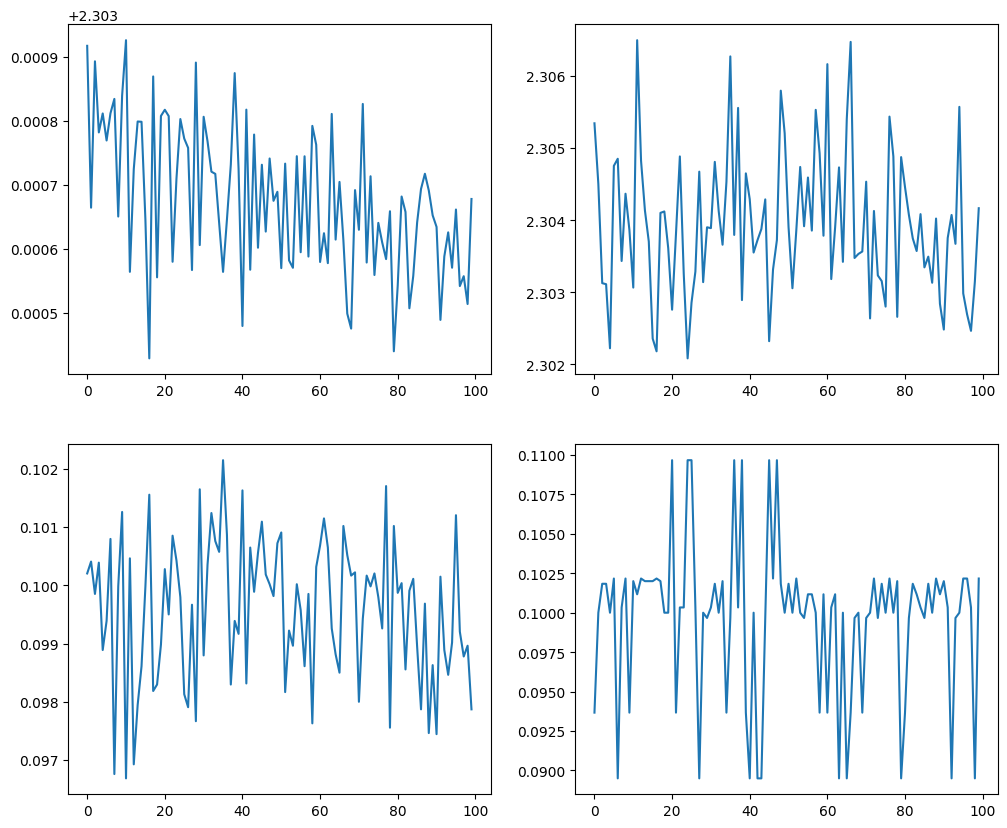

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, label='Train Loss')
ax[0, 1].plot(val_loss_lst, label='Val Loss')

ax[1, 0].plot(train_acc_lst, label='Train Acc')
ax[1, 1].plot(val_acc_lst, label='Val Acc')

plt.show()



In [ ]:
model.eval()
test_predict = []
test_target = []
with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test, y_test = X_test.to(device), y_test.to(device)
        outputs = model(X_test)
        test_predict.append(outputs.cpu())
        test_target.append(y_test.cpu())

    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = (torch.argmax(test_predict, 1) == test_target).sum().item() / len(test_target)
    print(f'Test Acc: {test_acc:.4f}')

Weight increasing + ReLu activation function + Adam optimizer + skip connection

In [16]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        self.hidden_dims = hidden_dims # Assign hidden_dims as an attribute to the class

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=10.0)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.BatchNorm1d(self.hidden_dims)(x) # Correct the typo from Batchnorm1d to BatchNorm1d
        x = nn.ReLU()(x) # Correct the typo from Relu to ReLU
        skip = x

        x = self.layer2(x)
        x = nn.BatchNorm1d(self.hidden_dims)(x) # Correct the typo from Batchnorm1d to BatchNorm1d
        x = nn.ReLU()(x) # Correct the typo from Relu to ReLU

        x = self.layer3(x)
        x = nn.BatchNorm1d(self.hidden_dims)(x) # Correct the typo from Batchnorm1d to BatchNorm1d
        x = nn.ReLU()(x) # Correct the typo from Relu to ReLU
        x = x + skip
        x = self.layer4(x)
        x = nn.BatchNorm1d(self.hidden_dims)(x) # Correct the typo from Batchnorm1d to BatchNorm1d
        x = nn.ReLU()(x) # Correct the typo from Relu to ReLU
        skip = x

        x = self.layer5(x)
        x = nn.BatchNorm1d(self.hidden_dims)(x) # Correct the typo from Batchnorm1d to BatchNorm1d
        x = nn.ReLU()(x) # Correct the typo from Relu to ReLU
        x = self.layer6(x)
        x = nn.BatchNorm1d(self.hidden_dims)(x) # Correct the typo from Batchnorm1d to BatchNorm1d
        x = nn.ReLU()(x) # Correct the typo from Relu to ReLU
        x = self.layer7(x)
        x = nn.BatchNorm1d(self.hidden_dims)(x) # Correct the typo from Batchnorm1d to BatchNorm1d
        x = nn.ReLU()(x) # Correct the typo from Relu to ReLU
        x = x + skip
        out = self.output(x)
        return out



input_dims = 784
hidden_dims = 128
output_dims = 10
lr = 1e-2

model = MLP(input_dims, hidden_dims, output_dims).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)



In [17]:
# train model

epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0
    model.train()
    for X_train, y_train in train_loader:
      X_train, y_train = X_train.to(device), y_train.to(device)
      optimizer.zero_grad()
      outputs = model(X_train)
      loss = criterion(outputs, y_train)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
      train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
      count += len(y_train)

    train_loss /= len(train_loader)
    train_acc /= count
    train_loss_lst.append(train_loss)
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
      for X_val, y_val in val_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)
        outputs = model(X_val)
        loss = criterion(outputs, y_val)
        val_loss += loss.item()
        val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
        count += len(y_val)

    val_loss /= len(val_loader)
    val_acc /= count
    val_loss_lst.append(val_loss)
    val_acc_lst.append(val_acc)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

Epoch 1/100, Train Loss: 26.3544, Train Acc: 0.6355, Val Loss: 12.1669, Val Acc: 0.7100
Epoch 2/100, Train Loss: 8.6990, Train Acc: 0.7405, Val Loss: 7.4525, Val Acc: 0.7485
Epoch 3/100, Train Loss: 5.6387, Train Acc: 0.7648, Val Loss: 5.4644, Val Acc: 0.7618
Epoch 4/100, Train Loss: 4.0586, Train Acc: 0.7825, Val Loss: 4.0703, Val Acc: 0.7785
Epoch 5/100, Train Loss: 3.2044, Train Acc: 0.7877, Val Loss: 3.4351, Val Acc: 0.7793
Epoch 6/100, Train Loss: 2.5215, Train Acc: 0.7989, Val Loss: 2.8568, Val Acc: 0.7808
Epoch 7/100, Train Loss: 2.0772, Train Acc: 0.8025, Val Loss: 2.5062, Val Acc: 0.7782
Epoch 8/100, Train Loss: 1.7768, Train Acc: 0.8101, Val Loss: 2.0770, Val Acc: 0.7955
Epoch 9/100, Train Loss: 1.4917, Train Acc: 0.8177, Val Loss: 1.8422, Val Acc: 0.7960
Epoch 10/100, Train Loss: 1.3390, Train Acc: 0.8218, Val Loss: 1.6239, Val Acc: 0.7997
Epoch 11/100, Train Loss: 1.1439, Train Acc: 0.8278, Val Loss: 1.5462, Val Acc: 0.8057
Epoch 12/100, Train Loss: 1.0260, Train Acc: 0.832

Train layers separately + Gradients normalization

In [18]:
# gradient normalize
class GradientNormalization(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return input

    @staticmethod
    def backward(ctx, grad_output):
        mean = torch.mean(grad_output)
        std = torch.std(grad_output)
        grad_input = (grad_output - mean) / (std + 1e-6)
        return grad_input


class GradientNormalizationLayer(nn.Module):
    def __init__(self):
        super(GradientNormalizationLayer, self).__init__()

    def forward(self, x):
        return GradientNormalization.apply(x)

class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        self.hidden_dims = hidden_dims
        self.gradient_normalization = GradientNormalizationLayer()



In [21]:
# train layer seperately

class MPL_1layer(nn.Module):
    def __init__(self, input_dims, output_dims):
        super(MPL_1layer, self).__init__()
        self.layer1 = nn.Linear(input_dims, output_dims)
        #
        self.gradient_normalization = GradientNormalizationLayer()

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=10.0)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.BatchNorm1d(hidden_dims)(x)
        x = nn.ReLU()(x)
        return x

class MPL_2layer(nn.Module):
    def __init__(self, input_dims, output_dims):
        super(MPL_2layer, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, output_dims)
        self.gradient_normalization = GradientNormalizationLayer()

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=10.0)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.BatchNorm1d(hidden_dims)(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.BatchNorm1d(hidden_dims)(x)
        x = nn.ReLU()(x)
        return x


In [31]:
first = MPL_1layer(input_dims=784, output_dims=128)
second = MPL_2layer(input_dims=128, output_dims=128)
third = MPL_2layer(input_dims=128, output_dims=128)
fourth = MPL_2layer(input_dims=128, output_dims=128)

lr = 1e-2
criterion = nn.CrossEntropyLoss()
model = nn.Sequential(first, nn.Linear(128, 10))
optimizer = optim.Adam(first.parameters(), lr=lr)

# train model

epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0
    model.train()
    for X_train, y_train in train_loader:
      X_train, y_train = X_train.to(device), y_train.to(device)
      optimizer.zero_grad()
      outputs = model(X_train)
      loss = criterion(outputs, y_train)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
      train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
      count += len(y_train)

    train_loss /= len(train_loader)
    train_acc /= count
    train_loss_lst.append(train_loss)
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
      for X_val, y_val in val_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)
        outputs = model(X_val)
        loss = criterion(outputs, y_val)
        val_loss += loss.item()
        val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
        count += len(y_val)

    val_loss /= len(val_loader)
    val_acc /= count
    val_loss_lst.append(val_loss)
    val_acc_lst.append(val_acc)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')


Epoch 1/100, Train Loss: 1.2514, Train Acc: 0.6684, Val Loss: 0.9894, Val Acc: 0.7595
Epoch 2/100, Train Loss: 0.9119, Train Acc: 0.7858, Val Loss: 0.8830, Val Acc: 0.7898
Epoch 3/100, Train Loss: 0.8387, Train Acc: 0.8078, Val Loss: 0.8348, Val Acc: 0.8057
Epoch 4/100, Train Loss: 0.8010, Train Acc: 0.8182, Val Loss: 0.8060, Val Acc: 0.8123
Epoch 5/100, Train Loss: 0.7774, Train Acc: 0.8245, Val Loss: 0.7870, Val Acc: 0.8185
Epoch 6/100, Train Loss: 0.7602, Train Acc: 0.8292, Val Loss: 0.7727, Val Acc: 0.8247
Epoch 7/100, Train Loss: 0.7472, Train Acc: 0.8326, Val Loss: 0.7626, Val Acc: 0.8252
Epoch 8/100, Train Loss: 0.7375, Train Acc: 0.8350, Val Loss: 0.7536, Val Acc: 0.8298
Epoch 9/100, Train Loss: 0.7309, Train Acc: 0.8362, Val Loss: 0.7470, Val Acc: 0.8303
Epoch 10/100, Train Loss: 0.7232, Train Acc: 0.8378, Val Loss: 0.7424, Val Acc: 0.8313
Epoch 11/100, Train Loss: 0.7180, Train Acc: 0.8396, Val Loss: 0.7372, Val Acc: 0.8315
Epoch 12/100, Train Loss: 0.7134, Train Acc: 0.8421,

In [30]:

for params in first.parameters():
    params.requires_grad = False
for params in second.parameters():
    params.requires_grad = False

model = nn.Sequential(first, second, third,nn.Linear(128, 10)).to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)

# train model

epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0
    model.train()
    for X_train, y_train in train_loader:
      X_train, y_train = X_train.to(device), y_train.to(device)
      optimizer.zero_grad()
      outputs = model(X_train)
      loss = criterion(outputs, y_train)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
      train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
      count += len(y_train)

    train_loss /= len(train_loader)
    train_acc /= count
    train_loss_lst.append(train_loss)
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
      for X_val, y_val in val_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)
        outputs = model(X_val)
        loss = criterion(outputs, y_val)
        val_loss += loss.item()
        val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
        count += len(y_val)

    val_loss /= len(val_loader)
    val_acc /= count
    val_loss_lst.append(val_loss)
    val_acc_lst.append(val_acc)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x128 and 784x128)

In [25]:
for params in first.parameters():
    params.requires_grad = True
for params in second.parameters():
    params.requires_grad = True
for params in third.parameters():
    params.requires_grad = True

model = nn.Sequential(first, second, third, fourth, nn.Linear(128, 10)).to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)

# train model

epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0
    model.train()
    for X_train, y_train in train_loader:
      X_train, y_train = X_train.to(device), y_train.to(device)
      optimizer.zero_grad()
      outputs = model(X_train)
      loss = criterion(outputs, y_train)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
      train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
      count += len(y_train)

    train_loss /= len(train_loader)
    train_acc /= count
    train_loss_lst.append(train_loss)
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
      for X_val, y_val in val_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)
        outputs = model(X_val)
        loss = criterion(outputs, y_val)
        val_loss += loss.item()
        val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
        count += len(y_val)

    val_loss /= len(val_loader)
    val_acc /= count
    val_loss_lst.append(val_loss)
    val_acc_lst.append(val_acc)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x128 and 784x128)